In [1]:
from model_update.config import Config
from model_update.dataset import ComboDataset
from model_update.model import Model
import torch
import pytorch_lightning as pl
from model_update.utils import parse_data_cfg
from model_update.yolov3.utils.datasets import LoadImagesAndLabels

In [28]:
import numpy as np

In [2]:
config = Config(
    USE_YOLO=True,
    DATA_DIR="data",
    IMG_SIZE=640,
    MIN_IMG_SIZE=480,
    BATCH_SIZE=1,
    MIDAS_LOSS_WEIGHT=1,
    PLANERCNN_LOSS_WEIGHT=1,
    PREDICT_DEPTH=False,
    EPOCHS=1
)
dataset = ComboDataset(config)
val_dataset = ComboDataset(config, train=False)
loader_val = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    collate_fn=val_dataset.collate_fn
)

Caching labels data\yolo\labels.npy (1001 found, 0 missing, 14 empty, 0 duplicate, for 1015 images): 100%|██████████| 1015/1015 [00:00<00:00, 13355.77it/s]
Caching labels data\yolo\labels.npy (99 found, 0 missing, 0 empty, 0 duplicate, for 99 images): 100%|██████████| 99/99 [00:00<00:00, 263.45it/s]


In [5]:
model = Model(config, 1000, 4, dataset.yolo_dataset.yolo_labels)

Loading weights:  weights/midas.pt
Using cache found in C:\Users\guddu/.cache\torch\hub\facebookresearch_WSL-Images_master
config/yolov3-head.cfg
Model Summary: 147 layers, 5.93877e+07 parameters, 5.93877e+07 gradients
Using cache found in C:\Users\guddu/.cache\torch\hub\ultralytics_yolov3_master

                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     20672  models.common.Bottleneck                [64, 64]                      
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    164608  models.common.Bottleneck                [128, 128]                    
  5                -1  1    295424  models.common.Conv     

In [7]:
model.load_state_dict(torch.load("trained_model.bin"))

<All keys matched successfully>

In [8]:
model = model.eval()

In [12]:
sample_img = next(iter(loader_val))
len(sample_img)
l1, l2, l3, l4, midas_out = model.midas_net(sample_img[0])
ra,b,c,d = sample_img  
from fox.yolov3.utils.torch_utils import ModelEMA
yolo_ema = ModelEMA(model.yolo_part)
s = yolo_ema.ema(l2)
inf_out,_ = s

from fox.yolov3.utils.utils import (
    labels_to_class_weights,
    non_max_suppression,
    output_to_target,
)

output = non_max_suppression(
                    inf_out,
                    conf_thres=model.config.yolo_config.opt.conf_thres,
                    iou_thres=model.config.yolo_config.opt.iou_thres,
                )
                
    
from fox.utils import plot_yolo_bbox, construct_midas_depth, visualize_planercnn, visualize_planercnn_batch

res_img = plot_yolo_bbox(
                    c[0],
                    output_to_target(output, c[0].shape[-1], c[0].shape[-2]),
                    names=["hardhat", "vest", "mask", "boots"],
                )

[[    0.47461     0.47075     0.25474      0.2881     0.25666     0.45531     0.47346     0.47306     0.26729     0.47336     0.58784      0.3512     0.29536      0.3512      0.3512      0.3512     0.25214     0.16391     0.48825      0.4698     0.44968     0.41376     0.46912     0.25327     0.25567     0.12009
      0.49777     0.28756     0.16979     0.25312     0.25682     0.51892     0.28571     0.50952     0.25638     0.33977     0.46308     0.53139     0.29048     0.25714     0.24881     0.47035     0.51789     0.30805    0.026905     0.28149     0.29164     0.45042     0.45546     0.53004     0.38429     0.51892
      0.28009     0.44935     0.51892     0.51892     0.49235      0.4557     0.13052     0.29992     0.28808      0.2899     0.27405     0.27897     0.30798     0.41376     0.53139     0.51742     0.34442     0.39348      0.4861     0.53139     0.49399     0.59264       0.579     0.41376     0.25868     0.21561
      0.53139     0.12009     0.29686     0.49454     0.51

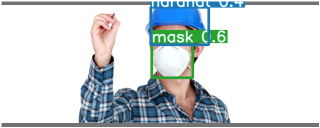

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(res_img)
im

In [15]:
im.save("YoloOut.png",format="png")

In [16]:
###Midasoutput